In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import taxcalc as tc
from taxbrain import (
    TaxBrain, differences_plot, distribution_plot, volcano_plot
)
from bokeh.io import output_notebook, show

In [2]:
output_notebook()
pd.options.display.float_format = '{:,.3f}'.format

Loading BokehJS ...

In [3]:
# Set paths to work across Mac/Windows/Linux platforms
# Update cur_path to the path of the repsitory on your local machine
cur_path = "/Users/richardevans/Docs/Economics/OSE/Federal/CharitableContrib"
data_dir = os.path.join(cur_path, 'data')
images_dir = os.path.join(cur_path, 'images')
# Directories to save data
json_dir = os.path.join(cur_path, "json")
base_dir = os.path.join(cur_path, "OUTPUT_BASELINE")
reform_dir_chddct = os.path.join(cur_path, "OUTPUT_REFORM_CHDDCT")
tmd_dir = (
    "/Users/richardevans/Docs/Economics/OSE/microsim/" +
    "tax-microdata-benchmarking/tmd/storage/output"
)

## 1. Create descriptive images

In [4]:
# Create a Pandas DataFrame of percent of filers who take the standard
# deduction.
# 2022:
# 2021: https://www.irs.gov/pub/irs-pdf/p1304.pdf
# 2020: https://www.irs.gov/pub/irs-soi/soi-a-inpr-id2201.pdf
# 2019: https://www.irs.gov/pub/irs-prior/p1304--2021.pdf
# 2018: https://www.irs.gov/pub/irs-prior/p1304--2020.pdf
# 2017: https://www.irs.gov/pub/irs-soi/17inintaxreturns.pdf
# 2016: https://www.irs.gov/pub/irs-soi/16inintaxreturns.pdf
# 2015: https://www.irs.gov/pub/irs-soi/15inintaxreturns.pdf
pct_std_deduct = pd.DataFrame({
    'year': [2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015],
    'pct_std_deduct': [88.6, 88.2, 87.5, 88.9, 87.3, 68.0, 68.6, 69.0],
    'std_deduct_joint': [
        25900, 25100, 24800, 24400, 24000, 12700, 12600, 12600
    ],
    'std_deduct_single': [
        12950, 12550, 12400, 12200, 12000, 6350, 6300, 6300
    ],
    'chtbl_deduct_nonitem_joint': [0, 600, 300, 0, 0, 0, 0, 0],
    'chtbl_deduct_nonitem_other': [0, 300, 150, 0, 0, 0, 0, 0],
})
pct_std_deduct['std_deduct_plus_joint'] = (
    pct_std_deduct['std_deduct_joint'] +
    pct_std_deduct['chtbl_deduct_nonitem_joint']
)
pct_std_deduct['std_deduct_plus_other'] = (
    pct_std_deduct['std_deduct_single'] +
    pct_std_deduct['chtbl_deduct_nonitem_other']
)

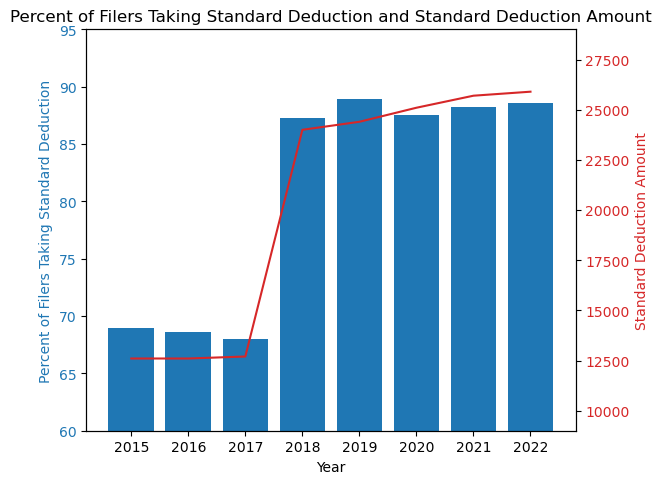

In [5]:
# Make a plot with a left y-axis for the percent of filers who take the
# standard deduction and a right y-axis for the std_deduct_joint amount.
fig1, ax1 = plt.subplots()
color_pct = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Percent of Filers Taking Standard Deduction', color=color_pct)
ax1.bar(
    pct_std_deduct['year'], pct_std_deduct['pct_std_deduct'], color=color_pct,
    label='Percent of Filers Taking Standard Deduction'
)
ax1.tick_params(axis='y', labelcolor=color_pct)
ax2 = ax1.twinx()
color_std = 'tab:red'
ax2.set_ylabel('Standard Deduction Amount', color=color_std)
ax2.plot(
    pct_std_deduct['year'], pct_std_deduct['std_deduct_plus_joint'],
    color=color_std, label='Standard Deduction Amount (married, joint)'
)
ax2.tick_params(axis='y', labelcolor=color_std)
# Set ax1 y-axis limits to 20-100 and ax2 y-axis limits to 10000-30000.
ax1.set_ylim(60, 95)
ax2.set_ylim(9000, 29000)
fig1.tight_layout()
plt.title(
    'Percent of Filers Taking Standard Deduction and Standard Deduction Amount'
)
# plt.legend(loc='upper left')
# Save the plot as StdDeduct_pct_take.png in the images_dir directory.
plt.savefig(os.path.join(images_dir, 'StdDeduct_pct_take.png'))
plt.show()

In [40]:
# Read in data
item_by_agi_dir = os.path.join(data_dir, "IRS_SOI/item_by_agi")
item_by_age_dir = os.path.join(data_dir, "IRS_SOI/item_by_age")
inc_range_lst = [
    "all_returns_total", "under_5k", "5k-10k", "10k-15k", "15k-20k", "20k-25k",
    "25k-30k", "30k-35k", "35k-40k", "40k-45k", "45k-50k", "50k-55k",
    "55k-60k", "60k-75k", "75k-100k", "100k-200k", "200k-500k", "500k-1m",
    "1m-1.5m", "1.5m-2m", "2m-5m", "5m-10m", "10m_over",
    "taxable_returns_total", "nontaxable_returns_total"
]
age_range_lst = [
    "all_returns", "under_18", "18-25", "26-34", "35-44", "45-54", "55-64",
    "65_over"
]
var_list = [
    "num_returns", "agi_less_def", "total_income", "item_ded_tot",
    "contrib_num", "contrib_tot"
]
var_col_sheet_names_agi = [
    ["B", "C", "E", "BH", "CS", "CT"],
    ["B", "C", "E", "BH", "CS", "CT"],
    ["B", "C", "E", "BJ", "CU", "CV"],
    ["B", "C", "E", "BL", "CY", "CZ"],
    ["B", "C", "E", "BN", "DC", "DD"],
    ["B", "C", "E", "BJ", "CY", "CZ"],
    ["B", "C", "E", "BH", "CW", "CX"],
    ["B", "C", "E", "BT", "DG", "DH"]]
# Create blank DataFrame for data by AGI and data by age for each variable with
# dates as rows and income ranges or age ranges as columns/variables
year_lst = list(range(2015, 2023))
for var in var_list:
    if var == "num_returns" or var == "contrib_num":
        data_type = "int64"
    else:
        data_type = "float64"
    exec(
        f"{var}_age_df = pd.DataFrame(columns=['year']+age_range_lst, dtype=np.{data_type})"
    )
    exec(
        f"{var}_agi_df = pd.DataFrame(columns=['year']+inc_range_lst, dtype=np.{data_type})"
    )

for ind_year, year in enumerate(year_lst):  # Loop through years 2015 to 2022
    two_digit_year = str(year)[2:]  # Get the last two digits of the year
    for ind_var, var in enumerate(var_list):
        print(year, var)
        # Add a row to the DataFrame and set the year = year
        exec(f"{var}_age_df.loc[ind_year, 'year'] = year")
        exec(f"{var}_agi_df.loc[ind_year, 'year'] = year")
        # Create a list from the column of an xls file
        age_data = pd.read_excel(
            os.path.join(item_by_age_dir, f"{two_digit_year}in26ag.xls"),
            sheet_name="TBL21", header=None, names=["variable"],
            usecols=var_col_sheet_names_agi[ind_year][ind_var],
            skiprows=9, nrows=8
        )["variable"].tolist()
        exec(f"{var}_age_df.loc[ind_year, age_range_lst] = age_data")
        agi_data = pd.read_excel(
            os.path.join(item_by_agi_dir, f"{two_digit_year}in21id.xls"),
            sheet_name="TBL21", header=None, names=["variable"],
            usecols=var_col_sheet_names_agi[ind_year][ind_var],
            skiprows=9, nrows=25
        )["variable"].tolist()
        exec(f"{var}_agi_df.loc[ind_year, inc_range_lst] = agi_data")

irs_soi_data_dct = {
    "num_returns_age": num_returns_age_df,
    "agi_less_def_age": agi_less_def_age_df,
    "total_income_age": total_income_age_df,
    "item_ded_tot_age": item_ded_tot_age_df,
    "contrib_num_age": contrib_num_age_df,
    "contrib_tot_age": contrib_tot_age_df,
    "num_returns_agi": num_returns_agi_df,
    "agi_less_def_agi": agi_less_def_agi_df,
    "total_income_agi": total_income_agi_df,
    "item_ded_tot_agi": item_ded_tot_agi_df,
    "contrib_num_agi": contrib_num_agi_df,
    "contrib_tot_agi": contrib_tot_agi_df
}


2015 num_returns
2015 agi_less_def
2015 total_income
2015 item_ded_tot
2015 contrib_num
2015 contrib_tot
2016 num_returns
2016 agi_less_def
2016 total_income
2016 item_ded_tot
2016 contrib_num
2016 contrib_tot
2017 num_returns
2017 agi_less_def
2017 total_income
2017 item_ded_tot
2017 contrib_num
2017 contrib_tot
2018 num_returns
2018 agi_less_def
2018 total_income
2018 item_ded_tot
2018 contrib_num
2018 contrib_tot
2019 num_returns
2019 agi_less_def
2019 total_income
2019 item_ded_tot
2019 contrib_num
2019 contrib_tot
2020 num_returns
2020 agi_less_def
2020 total_income
2020 item_ded_tot
2020 contrib_num
2020 contrib_tot
2021 num_returns
2021 agi_less_def
2021 total_income
2021 item_ded_tot
2021 contrib_num
2021 contrib_tot
2022 num_returns
2022 agi_less_def
2022 total_income
2022 item_ded_tot
2022 contrib_num
2022 contrib_tot


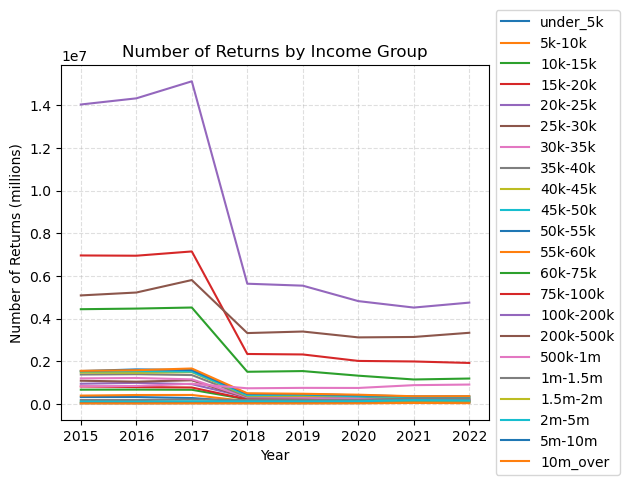

In [41]:
# Plot the time series of number of returns by income group
for var in inc_range_lst:
    if var not in ["all_returns_total", "taxable_returns_total", "nontaxable_returns_total"]:
        plt.plot(num_returns_agi_df['year'], num_returns_agi_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Number of Returns (millions)')
plt.title('Number of Returns by Income Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'NumReturns_inc.png'))
plt.show()

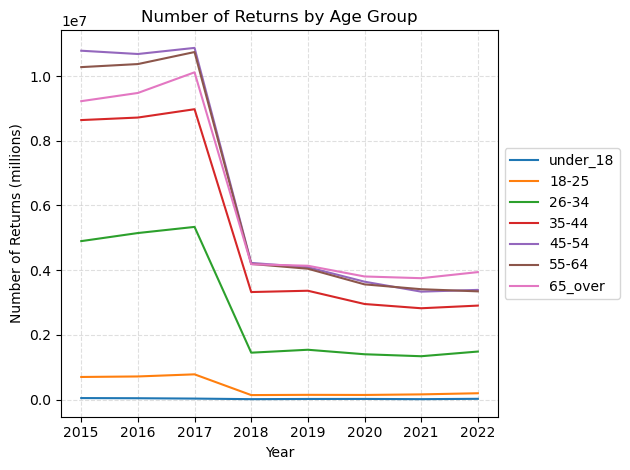

In [42]:
# Plot the time series of number of returns by age group
for var in age_range_lst:
    if var not in ["all_returns"]:
        plt.plot(num_returns_age_df['year'], num_returns_age_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Number of Returns (millions)')
plt.title('Number of Returns by Age Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'NumReturns_age.png'))
plt.show()

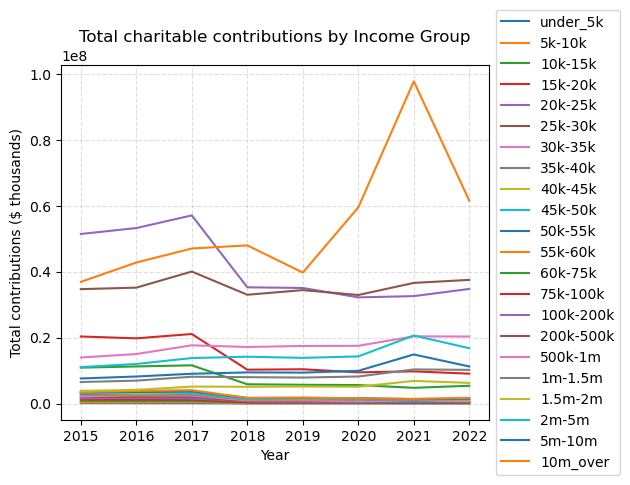

In [48]:
# Plot the time series of total contributions amount by income group
for var in inc_range_lst:
    if var not in ["all_returns_total", "taxable_returns_total", "nontaxable_returns_total"]:
        # if var in ["2m-5m", "5m-10m", "10m_over"]:
        #     plt.plot(contrib_tot_agi_df['year'], contrib_tot_agi_df[var], label=var, color='black')
        # else:
        #     plt.plot(contrib_tot_agi_df['year'], contrib_tot_agi_df[var], label=var)
        plt.plot(contrib_tot_agi_df['year'], contrib_tot_agi_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total contributions ($ thousands)')
plt.title('Total charitable contributions by Income Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContrib_inc.png'))
plt.show()

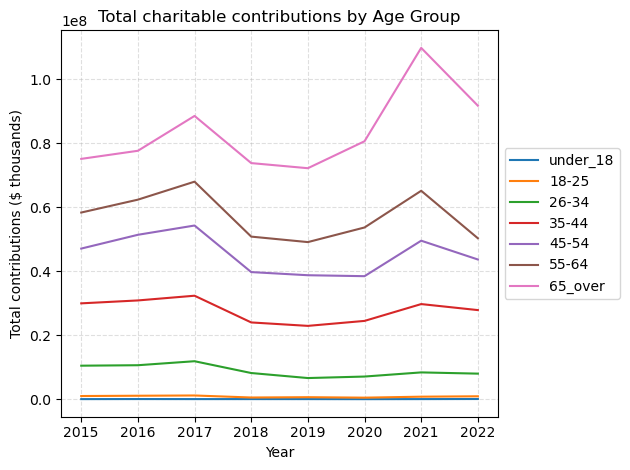

In [44]:
# Plot the time series of total contributions amount by age group
for var in age_range_lst:
    if var not in ["all_returns"]:
        plt.plot(contrib_tot_age_df['year'], contrib_tot_age_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total contributions ($ thousands)')
plt.title('Total charitable contributions by Age Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContrib_age.png'))
plt.show()

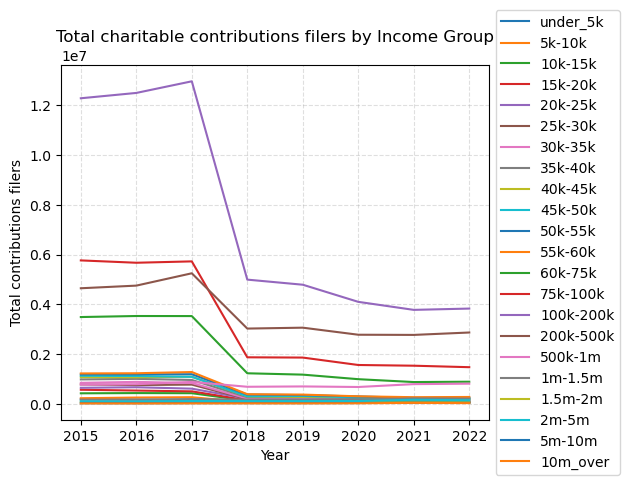

In [45]:
# Plot the time series of total contributions filers by income group
for var in inc_range_lst:
    if var not in ["all_returns_total", "taxable_returns_total", "nontaxable_returns_total"]:
        plt.plot(contrib_num_agi_df['year'], contrib_num_agi_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total contributions filers')
plt.title('Total charitable contributions filers by Income Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContrib_num_inc.png'))
plt.show()

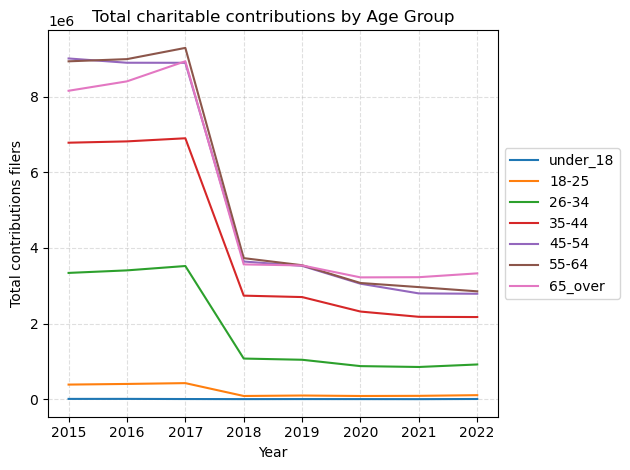

In [46]:
# Plot the time series of total contributions filers amount by age group
for var in age_range_lst:
    if var not in ["all_returns"]:
        plt.plot(contrib_num_age_df['year'], contrib_num_age_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total contributions filers')
plt.title('Total charitable contributions by Age Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContrib_num_age.png'))
plt.show()

## 2. Run Tax-Calculator analysis

### 2.1. Static analysis

In [17]:
start_year = 2025
end_year = 2034
ref_base = tc.Policy.read_json_reform(os.path.join(json_dir, "ext.json"))
ref_chddct = tc.Policy.read_json_reform(os.path.join(json_dir, "chddct.json"))

In [20]:
# specify Tax-Brain object
# We use the TCJA extended baseline and the TMD data
TMD_dict = {
    "data": os.path.join(tmd_dir, "tmd.csv.gz"),
    "start_year": start_year,
    "growfactors": os.path.join(tmd_dir, "tmd_growfactors.csv"),
    "weights": os.path.join(tmd_dir, "tmd_weights.csv.gz"),
}
# tb_static = TaxBrain(
#     start_year, end_year, microdata=TMD_dict,
#     base_policy=ref_base, reform=ref_chddct
# )
tb_static = TaxBrain(
    start_year, end_year, microdata=TMD_dict,
    base_policy={}, reform=ref_chddct
)
# Simulate the model
tb_static.run()

In [21]:
# print tables
print("Combined Tax Liability Over the Budget Window")
print((tb_static.weighted_totals("combined", include_total=True) / 1e9).to_markdown())  # division to put in billions, make sure this is correct. Look at Jason's notebook.
# Also see JEC report JCX-11-20 (March 26, 2020, line 4, https://www.jct.gov/getattachment/2245461c-dd37-451e-93fd-d1c62e074087/x-11-20-5252.pdf)

Combined Tax Liability Over the Budget Window
|            |      2025 |     2026 |      2027 |      2028 |      2029 |      2030 |      2031 |      2032 |      2033 |      2034 |     Total |
|:-----------|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| Base       | 34.0086   | 37.7756  | 39.2285   | 40.7546   | 42.2727   | 44.0092   | 45.8121   | 47.6635   | 49.5095   | 51.4548   | 432.489   |
| Reform     | 34.3512   | 38.2945  | 39.7733   | 41.3256   | 42.8674   | 44.6323   | 46.4646   | 48.3465   | 50.2227   | 52.2      | 438.478   |
| Difference |  0.342534 |  0.51889 |  0.544772 |  0.570944 |  0.594722 |  0.623088 |  0.652509 |  0.682985 |  0.713179 |  0.745145 |   5.98877 |


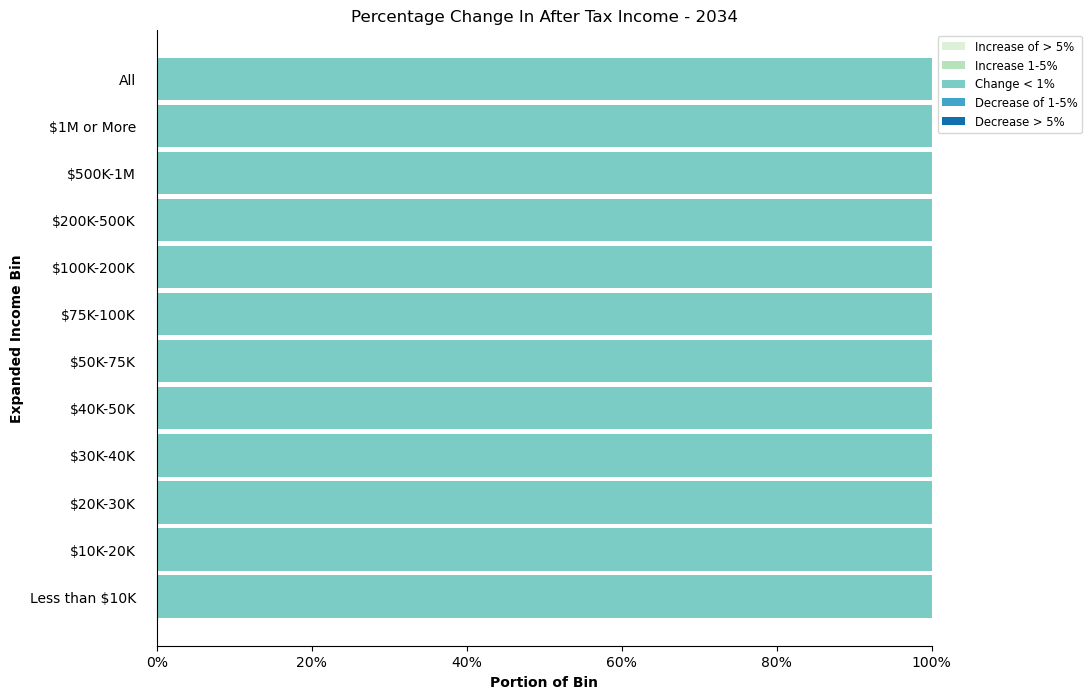

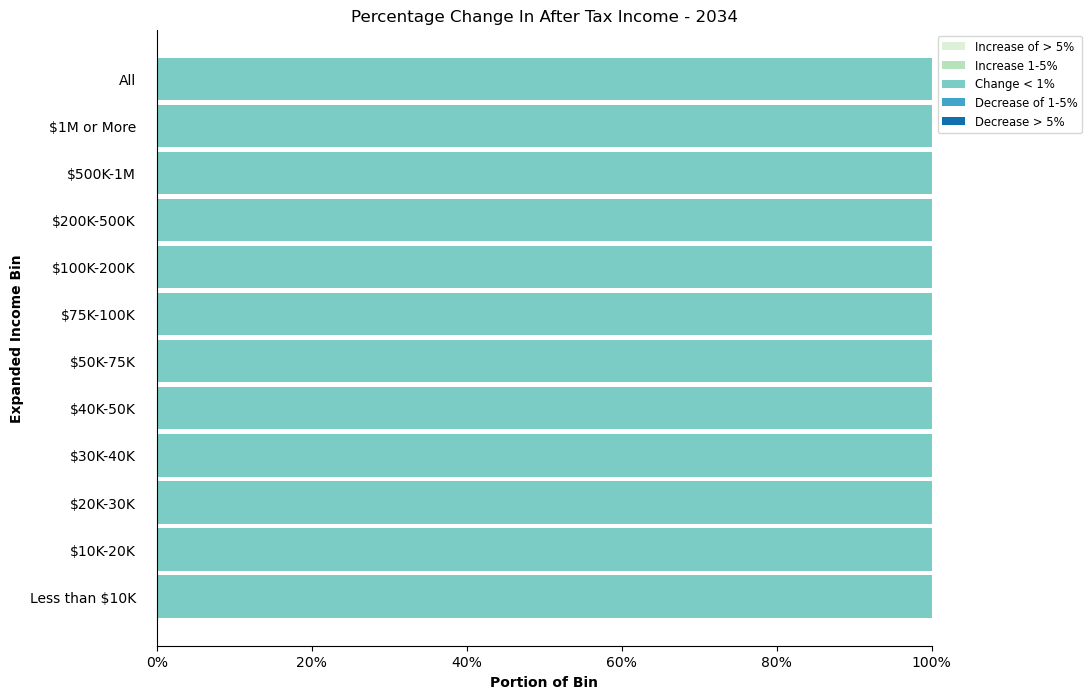

In [15]:
# Create distributional analysis bar plot
distribution_plot(tb_static, 2034, figsize=(10, 8))

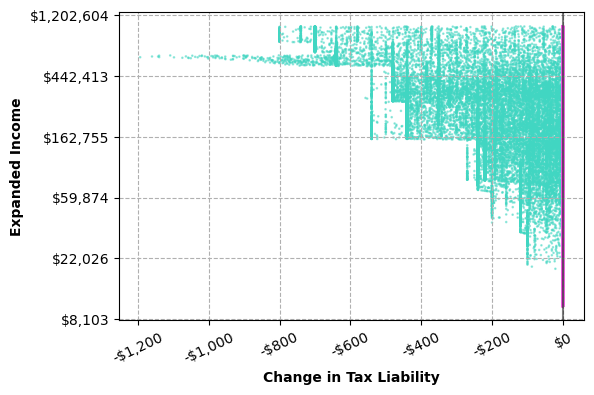

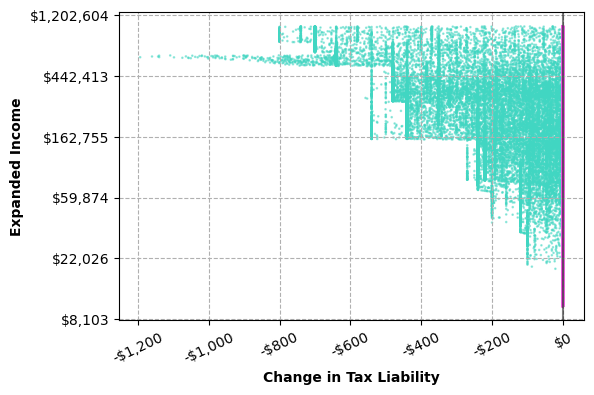

In [16]:
# Create volcano plot
volcano_plot(tb_static, year=2034, y_var="c00100", max_y=1_000_000, min_y=10_000)

### 2.2. Dynamic analysis (behavioral response)